In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
dataset = pd.read_csv('../../../data/zeda/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [5]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
# specify the number of lag hours
n_hours = 24*3
K = 12
S = 12

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [7]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96349, 336)


In [8]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+9),var4(t+9),var1(t+10),var2(t+10),var3(t+10),var4(t+10),var1(t+11),var2(t+11),var3(t+11),var4(t+11)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.39,1.38,1.75,1.92,1.92,1.88,2.22,2.41,2.38,2.33
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.92,1.88,2.22,2.41,2.38,2.33,2.34,2.51,2.53,2.46
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.38,2.33,2.34,2.51,2.53,2.46,2.07,2.31,2.32,2.26
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.53,2.46,2.07,2.31,2.32,2.26,1.41,1.66,1.63,1.59
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.32,2.26,1.41,1.66,1.63,1.59,0.78,1.03,1.01,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 08:00,2.16,2.17,2.23,2.210,1.96,2.11,2.13,2.12,1.63,1.67,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/31/20 09:00,1.96,2.11,2.13,2.120,1.63,1.67,1.76,1.69,1.13,1.16,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/31/20 10:00,1.63,1.67,1.76,1.690,1.13,1.16,1.26,1.22,0.75,0.74,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [9]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96349, 504)


In [10]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+10),var4(t+10),var5(t+10),var6(t+10),var1(t+11),var2(t+11),var3(t+11),var4(t+11),var5(t+11),var6(t+11)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,338.09,2.53,0.0,2.10,0.0,2.89,201.62,2.61
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,201.62,2.61,0.0,2.12,0.0,2.89,154.58,2.65
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.89,154.58,2.65,0.0,2.14,0.0,2.88,222.48,2.59
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.88,222.48,2.59,0.0,2.15,0.0,2.88,383.12,2.44
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.88,383.12,2.44,0.0,2.16,0.0,2.87,472.85,2.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 08:00,0.0,1.95,179.50,2.51,232.12,2.56,0.0,1.96,216.73,2.54,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/31/20 09:00,0.0,1.96,216.73,2.54,278.00,2.56,0.0,1.97,298.65,2.53,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/31/20 10:00,0.0,1.97,298.65,2.53,372.63,2.51,0.0,1.97,377.93,2.50,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [11]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96349, 756)


In [12]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+10),var1(t+11),var2(t+11),var3(t+11),var4(t+11),var5(t+11),var6(t+11),var7(t+11),var8(t+11),var9(t+11)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.28,...,0.0,2.28,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.73,...,0.0,2.30,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.85,...,0.0,2.02,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.49,...,0.0,1.34,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.21,...,0.0,0.77,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 08:00,2.03,0.0,0.0,2.57,0.0,0.0,2.63,0.0,0.0,1.91,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/31/20 09:00,1.91,0.0,0.0,2.57,0.0,0.0,2.63,0.0,0.0,1.50,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/31/20 10:00,1.50,0.0,0.0,2.57,0.0,0.0,2.63,0.0,0.0,1.00,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [13]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96349, 1260)


In [14]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [15]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 08:00,0.0,1.95,179.50,2.51,232.12,2.56,2.03,0.0,0.0,2.57,...,2.53,1.26,0.0,0.0,2.56,0.0,0.0,2.56,0.0,0.0
12/31/20 09:00,0.0,1.96,216.73,2.54,278.00,2.56,1.91,0.0,0.0,2.57,...,2.52,1.80,0.0,0.0,2.56,0.0,0.0,2.56,0.0,0.0
12/31/20 10:00,0.0,1.97,298.65,2.53,372.63,2.51,1.50,0.0,0.0,2.57,...,2.57,2.16,0.0,0.0,2.56,0.0,0.0,2.56,0.0,0.0


#### all target water stages in past $w$ hours

In [16]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [17]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 08:00,2.16,2.17,2.23,2.210,1.96,2.11,2.13,2.12,1.63,1.67,...,0.16,0.14,0.79,0.78,0.81,0.90,1.34,1.34,1.39,1.36
12/31/20 09:00,1.96,2.11,2.13,2.120,1.63,1.67,1.76,1.69,1.13,1.16,...,0.81,0.90,1.34,1.34,1.39,1.36,1.80,1.80,1.86,1.85
12/31/20 10:00,1.63,1.67,1.76,1.690,1.13,1.16,1.26,1.22,0.75,0.74,...,1.39,1.36,1.80,1.80,1.86,1.85,2.19,2.20,2.26,2.23


#### merge all data (ws, covariates) in past $w$ hours

In [18]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [19]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [20]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96344,0.0,1.95,179.50,2.51,232.12,2.56,2.03,0.0,0.0,2.57,...,2.56,0.0,0.0,2.56,0.0,0.0,1.34,1.34,1.39,1.36
96345,0.0,1.96,216.73,2.54,278.00,2.56,1.91,0.0,0.0,2.57,...,2.56,0.0,0.0,2.56,0.0,0.0,1.80,1.80,1.86,1.85
96346,0.0,1.97,298.65,2.53,372.63,2.51,1.50,0.0,0.0,2.57,...,2.56,0.0,0.0,2.56,0.0,0.0,2.19,2.20,2.26,2.23
96347,0.0,1.97,377.93,2.50,457.02,2.42,1.00,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.36,2.35,2.42,2.39


#### shift prior known covariates in future  $S$ steps to the past

In [21]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-60),shift_prior_known_supervised_var2(t-60),shift_prior_known_supervised_var3(t-60),shift_prior_known_supervised_var4(t-60),shift_prior_known_supervised_var5(t-60),shift_prior_known_supervised_var6(t-60),shift_prior_known_supervised_var7(t-60),shift_prior_known_supervised_var8(t-60),shift_prior_known_supervised_var9(t-60),shift_prior_known_supervised_var1(t-59),...,shift_prior_known_supervised_var9(t+10),shift_prior_known_supervised_var1(t+11),shift_prior_known_supervised_var2(t+11),shift_prior_known_supervised_var3(t+11),shift_prior_known_supervised_var4(t+11),shift_prior_known_supervised_var5(t+11),shift_prior_known_supervised_var6(t+11),shift_prior_known_supervised_var7(t+11),shift_prior_known_supervised_var8(t+11),shift_prior_known_supervised_var9(t+11)
0,1.01,0.0,0.0,0.00,0.0,0.0,2.63,0.0,0.000000,0.44,...,0.0,2.28,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0
1,0.44,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.16,...,0.0,2.30,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
2,-0.16,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.51,...,0.0,2.02,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
3,-0.51,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.59,...,0.0,1.34,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
4,-0.59,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.011875,-0.01,...,0.0,0.77,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96344,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96345,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96346,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96347,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.000000,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [22]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [23]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [24]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [25]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+11),shift_prior_known_supervised_var2(t+11),shift_prior_known_supervised_var3(t+11),shift_prior_known_supervised_var4(t+11),shift_prior_known_supervised_var5(t+11),shift_prior_known_supervised_var6(t+11),shift_prior_known_supervised_var7(t+11),shift_prior_known_supervised_var8(t+11),shift_prior_known_supervised_var9(t+11)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,2.28,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.30,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.02,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.34,0.0,0.0,0.0,0.0,0.0,2.64,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.77,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96344,0.0,1.95,179.50,2.51,232.12,2.56,2.03,0.0,0.0,2.57,...,1.36,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96345,0.0,1.96,216.73,2.54,278.00,2.56,1.91,0.0,0.0,2.57,...,1.85,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96346,0.0,1.97,298.65,2.53,372.63,2.51,1.50,0.0,0.0,2.57,...,2.23,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96347,0.0,1.97,377.93,2.50,457.02,2.42,1.00,0.0,0.0,2.57,...,2.39,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [26]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+9),var4(t+9),var1(t+10),var2(t+10),var3(t+10),var4(t+10),var1(t+11),var2(t+11),var3(t+11),var4(t+11)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.39,1.38,1.75,1.92,1.92,1.88,2.22,2.41,2.38,2.33
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.92,1.88,2.22,2.41,2.38,2.33,2.34,2.51,2.53,2.46
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.38,2.33,2.34,2.51,2.53,2.46,2.07,2.31,2.32,2.26
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.53,2.46,2.07,2.31,2.32,2.26,1.41,1.66,1.63,1.59
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.32,2.26,1.41,1.66,1.63,1.59,0.78,1.03,1.01,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96344,1.80,1.80,1.86,1.85,2.19,2.20,2.26,2.23,2.36,2.35,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96345,2.19,2.20,2.26,2.23,2.36,2.35,2.42,2.39,2.18,2.21,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96346,2.36,2.35,2.42,2.39,2.18,2.21,2.28,2.28,1.69,1.73,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96347,2.18,2.21,2.28,2.28,1.69,1.73,1.78,1.79,1.14,1.19,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [27]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96349, 2064)


In [28]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+9),var4(t+9),var1(t+10),var2(t+10),var3(t+10),var4(t+10),var1(t+11),var2(t+11),var3(t+11),var4(t+11)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.39,1.38,1.75,1.92,1.92,1.88,2.22,2.41,2.38,2.33
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.92,1.88,2.22,2.41,2.38,2.33,2.34,2.51,2.53,2.46
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.38,2.33,2.34,2.51,2.53,2.46,2.07,2.31,2.32,2.26
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.53,2.46,2.07,2.31,2.32,2.26,1.41,1.66,1.63,1.59
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.32,2.26,1.41,1.66,1.63,1.59,0.78,1.03,1.01,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96344,0.0,1.95,179.50,2.51,232.12,2.56,2.03,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96345,0.0,1.96,216.73,2.54,278.00,2.56,1.91,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96346,0.0,1.97,298.65,2.53,372.63,2.51,1.50,0.0,0.0,2.57,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96347,0.0,1.97,377.93,2.50,457.02,2.42,1.00,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [29]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77079


In [30]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [31]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77079, 2016) (77079, 48) (19270, 2016) (19270, 48)


In [32]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77079, 72, 28) (77079, 48) (19270, 72, 28) (19270, 48)


### Model

In [33]:
# define model
model_cnn = keras.Sequential()
model_cnn.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same", input_shape=(train_X.shape[1], train_X.shape[2])))
# model_cnn.add(layers.Conv2D(filters=64, 
#                                     kernel_size=3, 
#                                     activation='relu', 
#                                     padding="same",
#                                     input_shape=(train_X.shape[1], train_X.shape[2], 1)))
# model_cnn.add(layers.MaxPooling2D(pool_size=2))
model_cnn.add(layers.Flatten())
# model_cnn.add(layers.Dense(8, activation='relu'))
model_cnn.add(layers.Dense(train_y.shape[1]))
model_cnn.summary()

2022-09-22 15:57:59.377715: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-22 15:57:59.412094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 15:57:59.412353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-09-22 15:57:59.412565: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-09-22 15:57:59.413894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-22 15:57:59.415399: I tensorflow/stream_executor/platform/d

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 72, 64)            3648      
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 48)                221232    
Total params: 224,880
Trainable params: 224,880
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000


2022-09-22 15:58:01.477815: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-22 15:58:01.663858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7



Epoch 00001: val_mae improved from inf to 0.18877, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0880 - mae: 0.2356 - val_loss: 0.0576 - val_mae: 0.1888
Epoch 2/2000

Epoch 00002: val_mae improved from 0.18877 to 0.13906, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0232 - mae: 0.1210 - val_loss: 0.0304 - val_mae: 0.1391
Epoch 3/2000

Epoch 00003: val_mae improved from 0.13906 to 0.12202, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0166 - mae: 0.1023 - val_loss: 0.0238 - val_mae: 0.1220
Epoch 4/2000

Epoch 00004: val_mae improved from 0.12202 to 0.10807, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0132 - mae: 0.0903 - val_loss: 0.0190 - val_mae: 0.1081
Epoch 5/2000

Epoch 00005: val_mae improved from 0.10807 to 0.09631, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0106 - mae: 0.0798 - val_loss: 0.0154 - val_mae: 0.0963
Epoch 6/2000

Epoch 00006: val_m

Epoch 43/2000

Epoch 00043: val_mae improved from 0.04531 to 0.04486, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0019 - mae: 0.0322 - val_loss: 0.0034 - val_mae: 0.0449
Epoch 44/2000

Epoch 00044: val_mae improved from 0.04486 to 0.04442, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0018 - mae: 0.0318 - val_loss: 0.0033 - val_mae: 0.0444
Epoch 45/2000

Epoch 00045: val_mae improved from 0.04442 to 0.04400, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0018 - mae: 0.0315 - val_loss: 0.0032 - val_mae: 0.0440
Epoch 46/2000

Epoch 00046: val_mae improved from 0.04400 to 0.04359, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0017 - mae: 0.0311 - val_loss: 0.0032 - val_mae: 0.0436
Epoch 47/2000

Epoch 00047: val_mae improved from 0.04359 to 0.04318, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 0.0017 - mae: 0.0308 - val_loss: 0.0031 - val_mae: 0.0432
Epoch 48/2

Epoch 85/2000

Epoch 00085: val_mae improved from 0.03339 to 0.03322, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 9.0111e-04 - mae: 0.0221 - val_loss: 0.0018 - val_mae: 0.0332
Epoch 86/2000

Epoch 00086: val_mae improved from 0.03322 to 0.03305, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 8.8952e-04 - mae: 0.0219 - val_loss: 0.0018 - val_mae: 0.0331
Epoch 87/2000

Epoch 00087: val_mae improved from 0.03305 to 0.03289, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 8.7821e-04 - mae: 0.0218 - val_loss: 0.0018 - val_mae: 0.0329
Epoch 88/2000

Epoch 00088: val_mae improved from 0.03289 to 0.03273, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 8.6717e-04 - mae: 0.0216 - val_loss: 0.0018 - val_mae: 0.0327
Epoch 89/2000

Epoch 00089: val_mae improved from 0.03273 to 0.03258, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 8.5640e-04 - mae: 0.0215 - val_loss: 0.0018 - val_ma

Epoch 126/2000

Epoch 00126: val_mae improved from 0.02847 to 0.02838, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 5.8586e-04 - mae: 0.0176 - val_loss: 0.0013 - val_mae: 0.0284
Epoch 127/2000

Epoch 00127: val_mae improved from 0.02838 to 0.02829, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 5.8094e-04 - mae: 0.0175 - val_loss: 0.0013 - val_mae: 0.0283
Epoch 128/2000

Epoch 00128: val_mae improved from 0.02829 to 0.02820, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 5.7611e-04 - mae: 0.0174 - val_loss: 0.0013 - val_mae: 0.0282
Epoch 129/2000

Epoch 00129: val_mae improved from 0.02820 to 0.02811, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 5.7136e-04 - mae: 0.0173 - val_loss: 0.0013 - val_mae: 0.0281
Epoch 130/2000

Epoch 00130: val_mae improved from 0.02811 to 0.02802, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 5.6669e-04 - mae: 0.0173 - val_loss: 0.0013 - v

Epoch 167/2000

Epoch 00167: val_mae improved from 0.02511 to 0.02504, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 4.3670e-04 - mae: 0.0150 - val_loss: 0.0011 - val_mae: 0.0250
Epoch 168/2000

Epoch 00168: val_mae improved from 0.02504 to 0.02497, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 4.3405e-04 - mae: 0.0150 - val_loss: 0.0011 - val_mae: 0.0250
Epoch 169/2000

Epoch 00169: val_mae improved from 0.02497 to 0.02490, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 4.3143e-04 - mae: 0.0149 - val_loss: 0.0010 - val_mae: 0.0249
Epoch 170/2000

Epoch 00170: val_mae improved from 0.02490 to 0.02483, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 4.2885e-04 - mae: 0.0149 - val_loss: 0.0010 - val_mae: 0.0248
Epoch 171/2000

Epoch 00171: val_mae improved from 0.02483 to 0.02476, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 4.2630e-04 - mae: 0.0148 - val_loss: 0.0010 - v

Epoch 207/2000

Epoch 00207: val_mae improved from 0.02248 to 0.02242, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 3.5159e-04 - mae: 0.0133 - val_loss: 8.5348e-04 - val_mae: 0.0224
Epoch 208/2000

Epoch 00208: val_mae improved from 0.02242 to 0.02236, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 3.4989e-04 - mae: 0.0133 - val_loss: 8.4913e-04 - val_mae: 0.0224
Epoch 209/2000

Epoch 00209: val_mae improved from 0.02236 to 0.02230, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 3.4820e-04 - mae: 0.0132 - val_loss: 8.4484e-04 - val_mae: 0.0223
Epoch 210/2000

Epoch 00210: val_mae improved from 0.02230 to 0.02224, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 3.4654e-04 - mae: 0.0132 - val_loss: 8.4059e-04 - val_mae: 0.0222
Epoch 211/2000

Epoch 00211: val_mae improved from 0.02224 to 0.02219, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 3.4489e-04 - mae: 0.0132 - val_

Epoch 247/2000

Epoch 00247: val_mae improved from 0.02041 to 0.02037, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.9427e-04 - mae: 0.0121 - val_loss: 7.0727e-04 - val_mae: 0.0204
Epoch 248/2000

Epoch 00248: val_mae improved from 0.02037 to 0.02033, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.9308e-04 - mae: 0.0120 - val_loss: 7.0443e-04 - val_mae: 0.0203
Epoch 249/2000

Epoch 00249: val_mae improved from 0.02033 to 0.02028, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.9190e-04 - mae: 0.0120 - val_loss: 7.0156e-04 - val_mae: 0.0203
Epoch 250/2000

Epoch 00250: val_mae improved from 0.02028 to 0.02024, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.9074e-04 - mae: 0.0120 - val_loss: 6.9876e-04 - val_mae: 0.0202
Epoch 251/2000

Epoch 00251: val_mae improved from 0.02024 to 0.02020, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.8958e-04 - mae: 0.0119 - val_

Epoch 287/2000

Epoch 00287: val_mae improved from 0.01898 to 0.01895, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.5365e-04 - mae: 0.0111 - val_loss: 6.1287e-04 - val_mae: 0.0190
Epoch 288/2000

Epoch 00288: val_mae improved from 0.01895 to 0.01892, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.5280e-04 - mae: 0.0111 - val_loss: 6.1092e-04 - val_mae: 0.0189
Epoch 289/2000

Epoch 00289: val_mae improved from 0.01892 to 0.01889, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.5196e-04 - mae: 0.0110 - val_loss: 6.0908e-04 - val_mae: 0.0189
Epoch 290/2000

Epoch 00290: val_mae improved from 0.01889 to 0.01887, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.5112e-04 - mae: 0.0110 - val_loss: 6.0726e-04 - val_mae: 0.0189
Epoch 291/2000

Epoch 00291: val_mae improved from 0.01887 to 0.01884, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.5029e-04 - mae: 0.0110 - val_

Epoch 327/2000

Epoch 00327: val_mae improved from 0.01799 to 0.01797, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.2420e-04 - mae: 0.0103 - val_loss: 5.4985e-04 - val_mae: 0.0180
Epoch 328/2000

Epoch 00328: val_mae improved from 0.01797 to 0.01795, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.2357e-04 - mae: 0.0103 - val_loss: 5.4856e-04 - val_mae: 0.0179
Epoch 329/2000

Epoch 00329: val_mae improved from 0.01795 to 0.01793, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.2295e-04 - mae: 0.0103 - val_loss: 5.4731e-04 - val_mae: 0.0179
Epoch 330/2000

Epoch 00330: val_mae improved from 0.01793 to 0.01791, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.2233e-04 - mae: 0.0103 - val_loss: 5.4607e-04 - val_mae: 0.0179
Epoch 331/2000

Epoch 00331: val_mae improved from 0.01791 to 0.01789, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.2172e-04 - mae: 0.0103 - val_

Epoch 368/2000

Epoch 00368: val_mae did not improve from 0.01743
151/151 - 1s - loss: 2.0148e-04 - mae: 0.0097 - val_loss: 5.1573e-04 - val_mae: 0.0175
Epoch 369/2000

Epoch 00369: val_mae did not improve from 0.01743
151/151 - 1s - loss: 2.0100e-04 - mae: 0.0097 - val_loss: 5.1534e-04 - val_mae: 0.0174
Epoch 370/2000

Epoch 00370: val_mae improved from 0.01743 to 0.01743, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.0051e-04 - mae: 0.0097 - val_loss: 5.1409e-04 - val_mae: 0.0174
Epoch 371/2000

Epoch 00371: val_mae improved from 0.01743 to 0.01739, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 2.0001e-04 - mae: 0.0097 - val_loss: 5.1214e-04 - val_mae: 0.0174
Epoch 372/2000

Epoch 00372: val_mae improved from 0.01739 to 0.01735, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.9952e-04 - mae: 0.0096 - val_loss: 5.0987e-04 - val_mae: 0.0173
Epoch 373/2000

Epoch 00373: val_mae improved from 0.01735 to 0.01731, sa

Epoch 416/2000

Epoch 00416: val_mae improved from 0.01689 to 0.01682, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.8087e-04 - mae: 0.0091 - val_loss: 4.7829e-04 - val_mae: 0.0168
Epoch 417/2000

Epoch 00417: val_mae improved from 0.01682 to 0.01679, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.8054e-04 - mae: 0.0091 - val_loss: 4.7663e-04 - val_mae: 0.0168
Epoch 418/2000

Epoch 00418: val_mae did not improve from 0.01679
151/151 - 1s - loss: 1.8024e-04 - mae: 0.0091 - val_loss: 4.7732e-04 - val_mae: 0.0168
Epoch 419/2000

Epoch 00419: val_mae did not improve from 0.01679
151/151 - 1s - loss: 1.7993e-04 - mae: 0.0091 - val_loss: 4.8002e-04 - val_mae: 0.0169
Epoch 420/2000

Epoch 00420: val_mae did not improve from 0.01679
151/151 - 1s - loss: 1.7961e-04 - mae: 0.0091 - val_loss: 4.8416e-04 - val_mae: 0.0170
Epoch 421/2000

Epoch 00421: val_mae did not improve from 0.01679
151/151 - 1s - loss: 1.7926e-04 - mae: 0.0090 - val_loss: 4.8

Epoch 468/2000

Epoch 00468: val_mae did not improve from 0.01665
151/151 - 1s - loss: 1.6497e-04 - mae: 0.0086 - val_loss: 4.7985e-04 - val_mae: 0.0170
Epoch 469/2000

Epoch 00469: val_mae did not improve from 0.01665
151/151 - 1s - loss: 1.6528e-04 - mae: 0.0086 - val_loss: 4.9064e-04 - val_mae: 0.0171
Epoch 470/2000

Epoch 00470: val_mae did not improve from 0.01665
151/151 - 1s - loss: 1.6555e-04 - mae: 0.0086 - val_loss: 4.9958e-04 - val_mae: 0.0173
Epoch 471/2000

Epoch 00471: val_mae did not improve from 0.01665
151/151 - 1s - loss: 1.6577e-04 - mae: 0.0086 - val_loss: 5.0236e-04 - val_mae: 0.0173
Epoch 472/2000

Epoch 00472: val_mae did not improve from 0.01665
151/151 - 1s - loss: 1.6508e-04 - mae: 0.0086 - val_loss: 4.8523e-04 - val_mae: 0.0171
Epoch 473/2000

Epoch 00473: val_mae improved from 0.01665 to 0.01664, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.6378e-04 - mae: 0.0086 - val_loss: 4.6059e-04 - val_mae: 0.0166
Epoch 474/2000

Epoch 00474:

Epoch 520/2000

Epoch 00520: val_mae did not improve from 0.01608
151/151 - 1s - loss: 1.5286e-04 - mae: 0.0082 - val_loss: 4.6002e-04 - val_mae: 0.0167
Epoch 521/2000

Epoch 00521: val_mae did not improve from 0.01608
151/151 - 1s - loss: 1.5323e-04 - mae: 0.0082 - val_loss: 4.6907e-04 - val_mae: 0.0168
Epoch 522/2000

Epoch 00522: val_mae did not improve from 0.01608
151/151 - 1s - loss: 1.5412e-04 - mae: 0.0083 - val_loss: 4.8072e-04 - val_mae: 0.0170
Epoch 523/2000

Epoch 00523: val_mae did not improve from 0.01608
151/151 - 1s - loss: 1.5522e-04 - mae: 0.0083 - val_loss: 4.8619e-04 - val_mae: 0.0171
Epoch 524/2000

Epoch 00524: val_mae did not improve from 0.01608
151/151 - 1s - loss: 1.5574e-04 - mae: 0.0083 - val_loss: 4.7398e-04 - val_mae: 0.0169
Epoch 525/2000

Epoch 00525: val_mae did not improve from 0.01608
151/151 - 1s - loss: 1.5399e-04 - mae: 0.0083 - val_loss: 4.4221e-04 - val_mae: 0.0163
Epoch 526/2000

Epoch 00526: val_mae improved from 0.01608 to 0.01607, saving mode

Epoch 572/2000

Epoch 00572: val_mae did not improve from 0.01574
151/151 - 1s - loss: 1.4876e-04 - mae: 0.0081 - val_loss: 4.5570e-04 - val_mae: 0.0171
Epoch 573/2000

Epoch 00573: val_mae did not improve from 0.01574
151/151 - 1s - loss: 1.4612e-04 - mae: 0.0080 - val_loss: 4.2961e-04 - val_mae: 0.0163
Epoch 574/2000

Epoch 00574: val_mae did not improve from 0.01574
151/151 - 1s - loss: 1.4359e-04 - mae: 0.0079 - val_loss: 4.2573e-04 - val_mae: 0.0162
Epoch 575/2000

Epoch 00575: val_mae did not improve from 0.01574
151/151 - 1s - loss: 1.4329e-04 - mae: 0.0079 - val_loss: 4.3237e-04 - val_mae: 0.0162
Epoch 576/2000

Epoch 00576: val_mae did not improve from 0.01574
151/151 - 1s - loss: 1.4365e-04 - mae: 0.0079 - val_loss: 4.4296e-04 - val_mae: 0.0164
Epoch 577/2000

Epoch 00577: val_mae did not improve from 0.01574
151/151 - 1s - loss: 1.4449e-04 - mae: 0.0079 - val_loss: 4.5529e-04 - val_mae: 0.0166
Epoch 578/2000

Epoch 00578: val_mae did not improve from 0.01574
151/151 - 1s - l

Epoch 624/2000

Epoch 00624: val_mae did not improve from 0.01524
151/151 - 1s - loss: 1.3689e-04 - mae: 0.0077 - val_loss: 3.9502e-04 - val_mae: 0.0156
Epoch 625/2000

Epoch 00625: val_mae did not improve from 0.01524
151/151 - 1s - loss: 1.3862e-04 - mae: 0.0077 - val_loss: 4.1463e-04 - val_mae: 0.0162
Epoch 626/2000

Epoch 00626: val_mae did not improve from 0.01524
151/151 - 1s - loss: 1.4138e-04 - mae: 0.0079 - val_loss: 4.4614e-04 - val_mae: 0.0171
Epoch 627/2000

Epoch 00627: val_mae did not improve from 0.01524
151/151 - 1s - loss: 1.4215e-04 - mae: 0.0079 - val_loss: 4.4027e-04 - val_mae: 0.0169
Epoch 628/2000

Epoch 00628: val_mae did not improve from 0.01524
151/151 - 1s - loss: 1.3876e-04 - mae: 0.0078 - val_loss: 4.1462e-04 - val_mae: 0.0161
Epoch 629/2000

Epoch 00629: val_mae did not improve from 0.01524
151/151 - 1s - loss: 1.3603e-04 - mae: 0.0076 - val_loss: 4.1411e-04 - val_mae: 0.0160
Epoch 630/2000

Epoch 00630: val_mae did not improve from 0.01524
151/151 - 1s - l

Epoch 677/2000

Epoch 00677: val_mae did not improve from 0.01489
151/151 - 1s - loss: 1.3358e-04 - mae: 0.0076 - val_loss: 3.8980e-04 - val_mae: 0.0153
Epoch 678/2000

Epoch 00678: val_mae improved from 0.01489 to 0.01484, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.3194e-04 - mae: 0.0075 - val_loss: 3.6830e-04 - val_mae: 0.0148
Epoch 679/2000

Epoch 00679: val_mae did not improve from 0.01484
151/151 - 1s - loss: 1.3097e-04 - mae: 0.0075 - val_loss: 3.6844e-04 - val_mae: 0.0149
Epoch 680/2000

Epoch 00680: val_mae did not improve from 0.01484
151/151 - 1s - loss: 1.3086e-04 - mae: 0.0075 - val_loss: 3.7363e-04 - val_mae: 0.0151
Epoch 681/2000

Epoch 00681: val_mae did not improve from 0.01484
151/151 - 1s - loss: 1.3137e-04 - mae: 0.0075 - val_loss: 3.8370e-04 - val_mae: 0.0154
Epoch 682/2000

Epoch 00682: val_mae did not improve from 0.01484
151/151 - 1s - loss: 1.3279e-04 - mae: 0.0076 - val_loss: 4.0779e-04 - val_mae: 0.0162
Epoch 683/2000

Epoch 00683:

Epoch 730/2000

Epoch 00730: val_mae did not improve from 0.01474
151/151 - 1s - loss: 1.2765e-04 - mae: 0.0074 - val_loss: 3.8709e-04 - val_mae: 0.0156
Epoch 731/2000

Epoch 00731: val_mae did not improve from 0.01474
151/151 - 1s - loss: 1.2870e-04 - mae: 0.0074 - val_loss: 3.8658e-04 - val_mae: 0.0156
Epoch 732/2000

Epoch 00732: val_mae did not improve from 0.01474
151/151 - 1s - loss: 1.2723e-04 - mae: 0.0074 - val_loss: 3.8672e-04 - val_mae: 0.0155
Epoch 733/2000

Epoch 00733: val_mae did not improve from 0.01474
151/151 - 1s - loss: 1.2756e-04 - mae: 0.0074 - val_loss: 3.9520e-04 - val_mae: 0.0157
Epoch 734/2000

Epoch 00734: val_mae did not improve from 0.01474
151/151 - 1s - loss: 1.2583e-04 - mae: 0.0073 - val_loss: 3.7688e-04 - val_mae: 0.0152
Epoch 735/2000

Epoch 00735: val_mae did not improve from 0.01474
151/151 - 1s - loss: 1.2496e-04 - mae: 0.0072 - val_loss: 3.8050e-04 - val_mae: 0.0153
Epoch 736/2000

Epoch 00736: val_mae did not improve from 0.01474
151/151 - 1s - l

Epoch 783/2000

Epoch 00783: val_mae improved from 0.01420 to 0.01382, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.2317e-04 - mae: 0.0072 - val_loss: 3.2298e-04 - val_mae: 0.0138
Epoch 784/2000

Epoch 00784: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.2258e-04 - mae: 0.0072 - val_loss: 3.3319e-04 - val_mae: 0.0141
Epoch 785/2000

Epoch 00785: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.2276e-04 - mae: 0.0072 - val_loss: 3.5079e-04 - val_mae: 0.0147
Epoch 786/2000

Epoch 00786: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.2386e-04 - mae: 0.0072 - val_loss: 3.8341e-04 - val_mae: 0.0154
Epoch 787/2000

Epoch 00787: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.2269e-04 - mae: 0.0072 - val_loss: 3.8827e-04 - val_mae: 0.0155
Epoch 788/2000

Epoch 00788: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.2388e-04 - mae: 0.0072 - val_loss: 4.1134e-04 - val_mae: 0.0158
Epoch 789/2000

Epoch 00789:

Epoch 837/2000

Epoch 00837: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.1805e-04 - mae: 0.0070 - val_loss: 3.7687e-04 - val_mae: 0.0152
Epoch 838/2000

Epoch 00838: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.1809e-04 - mae: 0.0070 - val_loss: 3.8825e-04 - val_mae: 0.0153
Epoch 839/2000

Epoch 00839: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.1930e-04 - mae: 0.0071 - val_loss: 4.0464e-04 - val_mae: 0.0156
Epoch 840/2000

Epoch 00840: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.1997e-04 - mae: 0.0071 - val_loss: 3.8634e-04 - val_mae: 0.0152
Epoch 841/2000

Epoch 00841: val_mae did not improve from 0.01382
151/151 - 1s - loss: 1.1968e-04 - mae: 0.0071 - val_loss: 3.5935e-04 - val_mae: 0.0147
Epoch 842/2000

Epoch 00842: val_mae improved from 0.01382 to 0.01366, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.1814e-04 - mae: 0.0070 - val_loss: 3.2017e-04 - val_mae: 0.0137
Epoch 843/2000

Epoch 00843:

Epoch 890/2000

Epoch 00890: val_mae did not improve from 0.01354
151/151 - 1s - loss: 1.1587e-04 - mae: 0.0069 - val_loss: 3.9510e-04 - val_mae: 0.0156
Epoch 891/2000

Epoch 00891: val_mae did not improve from 0.01354
151/151 - 1s - loss: 1.1591e-04 - mae: 0.0069 - val_loss: 3.8609e-04 - val_mae: 0.0153
Epoch 892/2000

Epoch 00892: val_mae did not improve from 0.01354
151/151 - 1s - loss: 1.1521e-04 - mae: 0.0069 - val_loss: 3.4897e-04 - val_mae: 0.0144
Epoch 893/2000

Epoch 00893: val_mae did not improve from 0.01354
151/151 - 1s - loss: 1.1544e-04 - mae: 0.0069 - val_loss: 3.2698e-04 - val_mae: 0.0139
Epoch 894/2000

Epoch 00894: val_mae improved from 0.01354 to 0.01343, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.1637e-04 - mae: 0.0070 - val_loss: 3.1185e-04 - val_mae: 0.0134
Epoch 895/2000

Epoch 00895: val_mae did not improve from 0.01343
151/151 - 1s - loss: 1.1742e-04 - mae: 0.0070 - val_loss: 3.1047e-04 - val_mae: 0.0134
Epoch 896/2000

Epoch 00896:

Epoch 943/2000

Epoch 00943: val_mae did not improve from 0.01337
151/151 - 1s - loss: 1.1275e-04 - mae: 0.0068 - val_loss: 3.1956e-04 - val_mae: 0.0138
Epoch 944/2000

Epoch 00944: val_mae improved from 0.01337 to 0.01326, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.1167e-04 - mae: 0.0067 - val_loss: 3.0134e-04 - val_mae: 0.0133
Epoch 945/2000

Epoch 00945: val_mae did not improve from 0.01326
151/151 - 1s - loss: 1.1257e-04 - mae: 0.0068 - val_loss: 3.0290e-04 - val_mae: 0.0133
Epoch 946/2000

Epoch 00946: val_mae did not improve from 0.01326
151/151 - 1s - loss: 1.1417e-04 - mae: 0.0069 - val_loss: 3.1070e-04 - val_mae: 0.0135
Epoch 947/2000

Epoch 00947: val_mae did not improve from 0.01326
151/151 - 1s - loss: 1.1427e-04 - mae: 0.0069 - val_loss: 3.1148e-04 - val_mae: 0.0136
Epoch 948/2000

Epoch 00948: val_mae did not improve from 0.01326
151/151 - 1s - loss: 1.1347e-04 - mae: 0.0068 - val_loss: 3.1778e-04 - val_mae: 0.0139
Epoch 949/2000

Epoch 00949:

Epoch 996/2000

Epoch 00996: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.1058e-04 - mae: 0.0067 - val_loss: 3.0532e-04 - val_mae: 0.0134
Epoch 997/2000

Epoch 00997: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.1276e-04 - mae: 0.0068 - val_loss: 3.1261e-04 - val_mae: 0.0136
Epoch 998/2000

Epoch 00998: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.1288e-04 - mae: 0.0068 - val_loss: 2.9879e-04 - val_mae: 0.0133
Epoch 999/2000

Epoch 00999: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.1050e-04 - mae: 0.0067 - val_loss: 3.1108e-04 - val_mae: 0.0137
Epoch 1000/2000

Epoch 01000: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.0954e-04 - mae: 0.0067 - val_loss: 3.3754e-04 - val_mae: 0.0145
Epoch 1001/2000

Epoch 01001: val_mae did not improve from 0.01313
151/151 - 1s - loss: 1.0947e-04 - mae: 0.0067 - val_loss: 3.6298e-04 - val_mae: 0.0152
Epoch 1002/2000

Epoch 01002: val_mae did not improve from 0.01313
151/151 - 1s 

Epoch 1049/2000

Epoch 01049: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0866e-04 - mae: 0.0066 - val_loss: 3.0430e-04 - val_mae: 0.0136
Epoch 1050/2000

Epoch 01050: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0797e-04 - mae: 0.0066 - val_loss: 3.1915e-04 - val_mae: 0.0140
Epoch 1051/2000

Epoch 01051: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0840e-04 - mae: 0.0066 - val_loss: 3.4804e-04 - val_mae: 0.0148
Epoch 1052/2000

Epoch 01052: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0860e-04 - mae: 0.0066 - val_loss: 3.6364e-04 - val_mae: 0.0151
Epoch 1053/2000

Epoch 01053: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0888e-04 - mae: 0.0067 - val_loss: 3.6795e-04 - val_mae: 0.0151
Epoch 1054/2000

Epoch 01054: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0878e-04 - mae: 0.0067 - val_loss: 3.6536e-04 - val_mae: 0.0149
Epoch 1055/2000

Epoch 01055: val_mae did not improve from 0.01274
151/151 -

Epoch 1103/2000

Epoch 01103: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0524e-04 - mae: 0.0065 - val_loss: 3.4134e-04 - val_mae: 0.0147
Epoch 1104/2000

Epoch 01104: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0592e-04 - mae: 0.0065 - val_loss: 3.5912e-04 - val_mae: 0.0151
Epoch 1105/2000

Epoch 01105: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0638e-04 - mae: 0.0066 - val_loss: 3.6072e-04 - val_mae: 0.0151
Epoch 1106/2000

Epoch 01106: val_mae did not improve from 0.01274
151/151 - 2s - loss: 1.0589e-04 - mae: 0.0065 - val_loss: 3.5399e-04 - val_mae: 0.0149
Epoch 1107/2000

Epoch 01107: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0618e-04 - mae: 0.0065 - val_loss: 3.5874e-04 - val_mae: 0.0148
Epoch 1108/2000

Epoch 01108: val_mae did not improve from 0.01274
151/151 - 1s - loss: 1.0524e-04 - mae: 0.0065 - val_loss: 3.2753e-04 - val_mae: 0.0139
Epoch 1109/2000

Epoch 01109: val_mae did not improve from 0.01274
151/151 -

Epoch 1155/2000

Epoch 01155: val_mae did not improve from 0.01243
151/151 - 1s - loss: 1.0325e-04 - mae: 0.0064 - val_loss: 3.2782e-04 - val_mae: 0.0144
Epoch 1156/2000

Epoch 01156: val_mae did not improve from 0.01243
151/151 - 1s - loss: 1.0399e-04 - mae: 0.0064 - val_loss: 3.4618e-04 - val_mae: 0.0149
Epoch 1157/2000

Epoch 01157: val_mae did not improve from 0.01243
151/151 - 1s - loss: 1.0428e-04 - mae: 0.0065 - val_loss: 3.5483e-04 - val_mae: 0.0151
Epoch 1158/2000

Epoch 01158: val_mae did not improve from 0.01243
151/151 - 1s - loss: 1.0485e-04 - mae: 0.0065 - val_loss: 3.6523e-04 - val_mae: 0.0152
Epoch 1159/2000

Epoch 01159: val_mae did not improve from 0.01243
151/151 - 1s - loss: 1.0511e-04 - mae: 0.0065 - val_loss: 3.5596e-04 - val_mae: 0.0149
Epoch 1160/2000

Epoch 01160: val_mae did not improve from 0.01243
151/151 - 1s - loss: 1.0339e-04 - mae: 0.0064 - val_loss: 3.1856e-04 - val_mae: 0.0138
Epoch 1161/2000

Epoch 01161: val_mae did not improve from 0.01243
151/151 -

Epoch 1208/2000

Epoch 01208: val_mae did not improve from 0.01230
151/151 - 1s - loss: 1.0192e-04 - mae: 0.0064 - val_loss: 3.1603e-04 - val_mae: 0.0137
Epoch 1209/2000

Epoch 01209: val_mae did not improve from 0.01230
151/151 - 1s - loss: 1.0168e-04 - mae: 0.0063 - val_loss: 3.0798e-04 - val_mae: 0.0136
Epoch 1210/2000

Epoch 01210: val_mae did not improve from 0.01230
151/151 - 1s - loss: 1.0303e-04 - mae: 0.0064 - val_loss: 3.1403e-04 - val_mae: 0.0137
Epoch 1211/2000

Epoch 01211: val_mae did not improve from 0.01230
151/151 - 1s - loss: 1.0217e-04 - mae: 0.0064 - val_loss: 2.8094e-04 - val_mae: 0.0127
Epoch 1212/2000

Epoch 01212: val_mae did not improve from 0.01230
151/151 - 1s - loss: 1.0337e-04 - mae: 0.0064 - val_loss: 2.9050e-04 - val_mae: 0.0131
Epoch 1213/2000

Epoch 01213: val_mae did not improve from 0.01230
151/151 - 1s - loss: 1.0456e-04 - mae: 0.0065 - val_loss: 2.8146e-04 - val_mae: 0.0128
Epoch 1214/2000

Epoch 01214: val_mae did not improve from 0.01230
151/151 -

Epoch 1262/2000

Epoch 01262: val_mae did not improve from 0.01230
151/151 - 1s - loss: 9.9599e-05 - mae: 0.0062 - val_loss: 2.6672e-04 - val_mae: 0.0123
Epoch 1263/2000

Epoch 01263: val_mae improved from 0.01230 to 0.01225, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 1.0015e-04 - mae: 0.0063 - val_loss: 2.6481e-04 - val_mae: 0.0122
Epoch 1264/2000

Epoch 01264: val_mae did not improve from 0.01225
151/151 - 1s - loss: 1.0168e-04 - mae: 0.0064 - val_loss: 2.7071e-04 - val_mae: 0.0124
Epoch 1265/2000

Epoch 01265: val_mae did not improve from 0.01225
151/151 - 1s - loss: 1.0231e-04 - mae: 0.0064 - val_loss: 2.6455e-04 - val_mae: 0.0123
Epoch 1266/2000

Epoch 01266: val_mae did not improve from 0.01225
151/151 - 1s - loss: 1.0070e-04 - mae: 0.0063 - val_loss: 2.7110e-04 - val_mae: 0.0126
Epoch 1267/2000

Epoch 01267: val_mae did not improve from 0.01225
151/151 - 1s - loss: 9.9703e-05 - mae: 0.0062 - val_loss: 2.9717e-04 - val_mae: 0.0133
Epoch 1268/2000

Epoch

Epoch 1315/2000

Epoch 01315: val_mae did not improve from 0.01195
151/151 - 1s - loss: 1.0105e-04 - mae: 0.0063 - val_loss: 2.6512e-04 - val_mae: 0.0123
Epoch 1316/2000

Epoch 01316: val_mae did not improve from 0.01195
151/151 - 1s - loss: 1.0122e-04 - mae: 0.0063 - val_loss: 2.6675e-04 - val_mae: 0.0125
Epoch 1317/2000

Epoch 01317: val_mae did not improve from 0.01195
151/151 - 1s - loss: 1.0022e-04 - mae: 0.0063 - val_loss: 2.7209e-04 - val_mae: 0.0127
Epoch 1318/2000

Epoch 01318: val_mae did not improve from 0.01195
151/151 - 1s - loss: 9.8872e-05 - mae: 0.0062 - val_loss: 2.8748e-04 - val_mae: 0.0132
Epoch 1319/2000

Epoch 01319: val_mae did not improve from 0.01195
151/151 - 1s - loss: 9.8319e-05 - mae: 0.0062 - val_loss: 3.0714e-04 - val_mae: 0.0137
Epoch 1320/2000

Epoch 01320: val_mae did not improve from 0.01195
151/151 - 1s - loss: 9.8790e-05 - mae: 0.0062 - val_loss: 3.2816e-04 - val_mae: 0.0141
Epoch 1321/2000

Epoch 01321: val_mae did not improve from 0.01195
151/151 -

Epoch 1368/2000

Epoch 01368: val_mae did not improve from 0.01190
151/151 - 1s - loss: 9.7762e-05 - mae: 0.0062 - val_loss: 3.1629e-04 - val_mae: 0.0138
Epoch 1369/2000

Epoch 01369: val_mae did not improve from 0.01190
151/151 - 1s - loss: 9.7238e-05 - mae: 0.0062 - val_loss: 3.2412e-04 - val_mae: 0.0139
Epoch 1370/2000

Epoch 01370: val_mae did not improve from 0.01190
151/151 - 1s - loss: 9.8612e-05 - mae: 0.0062 - val_loss: 3.4936e-04 - val_mae: 0.0145
Epoch 1371/2000

Epoch 01371: val_mae did not improve from 0.01190
151/151 - 1s - loss: 1.0019e-04 - mae: 0.0063 - val_loss: 3.3861e-04 - val_mae: 0.0142
Epoch 1372/2000

Epoch 01372: val_mae did not improve from 0.01190
151/151 - 1s - loss: 9.7808e-05 - mae: 0.0062 - val_loss: 2.7526e-04 - val_mae: 0.0126
Epoch 1373/2000

Epoch 01373: val_mae did not improve from 0.01190
151/151 - 1s - loss: 9.5666e-05 - mae: 0.0061 - val_loss: 2.5620e-04 - val_mae: 0.0120
Epoch 1374/2000

Epoch 01374: val_mae did not improve from 0.01190
151/151 -

Epoch 1421/2000

Epoch 01421: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.6476e-05 - mae: 0.0061 - val_loss: 3.3399e-04 - val_mae: 0.0142
Epoch 1422/2000

Epoch 01422: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.6621e-05 - mae: 0.0061 - val_loss: 3.2516e-04 - val_mae: 0.0138
Epoch 1423/2000

Epoch 01423: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.6342e-05 - mae: 0.0061 - val_loss: 2.9678e-04 - val_mae: 0.0131
Epoch 1424/2000

Epoch 01424: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.5381e-05 - mae: 0.0061 - val_loss: 2.5983e-04 - val_mae: 0.0121
Epoch 1425/2000

Epoch 01425: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.5250e-05 - mae: 0.0060 - val_loss: 2.5547e-04 - val_mae: 0.0120
Epoch 1426/2000

Epoch 01426: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.7415e-05 - mae: 0.0062 - val_loss: 2.7261e-04 - val_mae: 0.0126
Epoch 1427/2000

Epoch 01427: val_mae did not improve from 0.01179
151/151 -

Epoch 1475/2000

Epoch 01475: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.6451e-05 - mae: 0.0061 - val_loss: 2.8976e-04 - val_mae: 0.0130
Epoch 1476/2000

Epoch 01476: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.5669e-05 - mae: 0.0061 - val_loss: 2.7435e-04 - val_mae: 0.0126
Epoch 1477/2000

Epoch 01477: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.5216e-05 - mae: 0.0061 - val_loss: 2.6568e-04 - val_mae: 0.0124
Epoch 1478/2000

Epoch 01478: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.5531e-05 - mae: 0.0061 - val_loss: 2.6979e-04 - val_mae: 0.0125
Epoch 1479/2000

Epoch 01479: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.6741e-05 - mae: 0.0061 - val_loss: 2.7319e-04 - val_mae: 0.0126
Epoch 1480/2000

Epoch 01480: val_mae did not improve from 0.01179
151/151 - 1s - loss: 9.6959e-05 - mae: 0.0062 - val_loss: 2.7280e-04 - val_mae: 0.0127
Epoch 1481/2000

Epoch 01481: val_mae did not improve from 0.01179
151/151 -

Epoch 1528/2000

Epoch 01528: val_mae did not improve from 0.01154
151/151 - 1s - loss: 9.3804e-05 - mae: 0.0060 - val_loss: 2.7667e-04 - val_mae: 0.0125
Epoch 1529/2000

Epoch 01529: val_mae did not improve from 0.01154
151/151 - 1s - loss: 9.2443e-05 - mae: 0.0059 - val_loss: 2.4598e-04 - val_mae: 0.0117
Epoch 1530/2000

Epoch 01530: val_mae improved from 0.01154 to 0.01145, saving model to saved_model/cnn_shift_s12_k12.h5
151/151 - 1s - loss: 9.2219e-05 - mae: 0.0059 - val_loss: 2.3939e-04 - val_mae: 0.0115
Epoch 1531/2000

Epoch 01531: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.3007e-05 - mae: 0.0060 - val_loss: 2.4715e-04 - val_mae: 0.0117
Epoch 1532/2000

Epoch 01532: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.5753e-05 - mae: 0.0061 - val_loss: 2.6846e-04 - val_mae: 0.0125
Epoch 1533/2000

Epoch 01533: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.8118e-05 - mae: 0.0062 - val_loss: 2.6333e-04 - val_mae: 0.0123
Epoch 1534/2000

Epoch

Epoch 1581/2000

Epoch 01581: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.3397e-05 - mae: 0.0060 - val_loss: 2.4596e-04 - val_mae: 0.0117
Epoch 1582/2000

Epoch 01582: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.5083e-05 - mae: 0.0061 - val_loss: 2.4305e-04 - val_mae: 0.0117
Epoch 1583/2000

Epoch 01583: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.4522e-05 - mae: 0.0061 - val_loss: 2.4010e-04 - val_mae: 0.0116
Epoch 1584/2000

Epoch 01584: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.3528e-05 - mae: 0.0060 - val_loss: 2.6820e-04 - val_mae: 0.0125
Epoch 1585/2000

Epoch 01585: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.3274e-05 - mae: 0.0060 - val_loss: 2.8626e-04 - val_mae: 0.0131
Epoch 1586/2000

Epoch 01586: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.3491e-05 - mae: 0.0060 - val_loss: 3.0447e-04 - val_mae: 0.0136
Epoch 1587/2000

Epoch 01587: val_mae did not improve from 0.01145
151/151 -

Epoch 1635/2000

Epoch 01635: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.3167e-05 - mae: 0.0060 - val_loss: 3.0371e-04 - val_mae: 0.0137
Epoch 1636/2000

Epoch 01636: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.2320e-05 - mae: 0.0059 - val_loss: 3.0580e-04 - val_mae: 0.0137
Epoch 1637/2000

Epoch 01637: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.1166e-05 - mae: 0.0059 - val_loss: 3.0276e-04 - val_mae: 0.0134
Epoch 1638/2000

Epoch 01638: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.0959e-05 - mae: 0.0059 - val_loss: 3.0711e-04 - val_mae: 0.0134
Epoch 1639/2000

Epoch 01639: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.1454e-05 - mae: 0.0059 - val_loss: 2.9950e-04 - val_mae: 0.0131
Epoch 1640/2000

Epoch 01640: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.1130e-05 - mae: 0.0059 - val_loss: 2.6492e-04 - val_mae: 0.0123
Epoch 1641/2000

Epoch 01641: val_mae did not improve from 0.01145
151/151 -

Epoch 1689/2000

Epoch 01689: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.1647e-05 - mae: 0.0059 - val_loss: 2.6529e-04 - val_mae: 0.0125
Epoch 1690/2000

Epoch 01690: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.1815e-05 - mae: 0.0059 - val_loss: 2.7976e-04 - val_mae: 0.0130
Epoch 1691/2000

Epoch 01691: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.1950e-05 - mae: 0.0059 - val_loss: 2.8047e-04 - val_mae: 0.0129
Epoch 1692/2000

Epoch 01692: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.0906e-05 - mae: 0.0059 - val_loss: 2.7364e-04 - val_mae: 0.0126
Epoch 1693/2000

Epoch 01693: val_mae did not improve from 0.01145
151/151 - 1s - loss: 8.9879e-05 - mae: 0.0058 - val_loss: 2.7697e-04 - val_mae: 0.0126
Epoch 1694/2000

Epoch 01694: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.0359e-05 - mae: 0.0058 - val_loss: 2.8336e-04 - val_mae: 0.0127
Epoch 1695/2000

Epoch 01695: val_mae did not improve from 0.01145
151/151 -

Epoch 1743/2000

Epoch 01743: val_mae did not improve from 0.01145
151/151 - 2s - loss: 9.2200e-05 - mae: 0.0060 - val_loss: 3.0405e-04 - val_mae: 0.0138
Epoch 1744/2000

Epoch 01744: val_mae did not improve from 0.01145
151/151 - 2s - loss: 9.1418e-05 - mae: 0.0059 - val_loss: 3.0298e-04 - val_mae: 0.0137
Epoch 1745/2000

Epoch 01745: val_mae did not improve from 0.01145
151/151 - 2s - loss: 9.1225e-05 - mae: 0.0059 - val_loss: 3.1652e-04 - val_mae: 0.0140
Epoch 1746/2000

Epoch 01746: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.1876e-05 - mae: 0.0059 - val_loss: 3.1817e-04 - val_mae: 0.0138
Epoch 1747/2000

Epoch 01747: val_mae did not improve from 0.01145
151/151 - 1s - loss: 9.1070e-05 - mae: 0.0059 - val_loss: 2.7843e-04 - val_mae: 0.0127
Epoch 1748/2000

Epoch 01748: val_mae did not improve from 0.01145
151/151 - 1s - loss: 8.9582e-05 - mae: 0.0058 - val_loss: 2.4514e-04 - val_mae: 0.0118
Epoch 1749/2000

Epoch 01749: val_mae did not improve from 0.01145
151/151 -

Epoch 1796/2000

Epoch 01796: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.9968e-05 - mae: 0.0058 - val_loss: 2.8686e-04 - val_mae: 0.0130
Epoch 1797/2000

Epoch 01797: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.9085e-05 - mae: 0.0058 - val_loss: 2.6143e-04 - val_mae: 0.0123
Epoch 1798/2000

Epoch 01798: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.8292e-05 - mae: 0.0057 - val_loss: 2.4439e-04 - val_mae: 0.0117
Epoch 1799/2000

Epoch 01799: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.9440e-05 - mae: 0.0058 - val_loss: 2.5200e-04 - val_mae: 0.0119
Epoch 1800/2000

Epoch 01800: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.9473e-05 - mae: 0.0058 - val_loss: 2.3441e-04 - val_mae: 0.0113
Epoch 1801/2000

Epoch 01801: val_mae did not improve from 0.01111
151/151 - 1s - loss: 9.0072e-05 - mae: 0.0058 - val_loss: 2.3794e-04 - val_mae: 0.0114
Epoch 1802/2000

Epoch 01802: val_mae did not improve from 0.01111
151/151 -

Epoch 1850/2000

Epoch 01850: val_mae did not improve from 0.01111
151/151 - 1s - loss: 9.1135e-05 - mae: 0.0059 - val_loss: 2.5633e-04 - val_mae: 0.0119
Epoch 1851/2000

Epoch 01851: val_mae did not improve from 0.01111
151/151 - 1s - loss: 9.1704e-05 - mae: 0.0060 - val_loss: 2.6254e-04 - val_mae: 0.0122
Epoch 1852/2000

Epoch 01852: val_mae did not improve from 0.01111
151/151 - 1s - loss: 9.0678e-05 - mae: 0.0059 - val_loss: 2.6454e-04 - val_mae: 0.0125
Epoch 1853/2000

Epoch 01853: val_mae did not improve from 0.01111
151/151 - 1s - loss: 9.0882e-05 - mae: 0.0059 - val_loss: 2.9419e-04 - val_mae: 0.0135
Epoch 1854/2000

Epoch 01854: val_mae did not improve from 0.01111
151/151 - 1s - loss: 9.0651e-05 - mae: 0.0059 - val_loss: 2.8701e-04 - val_mae: 0.0133
Epoch 1855/2000

Epoch 01855: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.8991e-05 - mae: 0.0058 - val_loss: 2.7617e-04 - val_mae: 0.0130
Epoch 1856/2000

Epoch 01856: val_mae did not improve from 0.01111
151/151 -

Epoch 1904/2000

Epoch 01904: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.8049e-05 - mae: 0.0058 - val_loss: 2.3417e-04 - val_mae: 0.0113
Epoch 1905/2000

Epoch 01905: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.8532e-05 - mae: 0.0058 - val_loss: 2.4717e-04 - val_mae: 0.0118
Epoch 1906/2000

Epoch 01906: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.9572e-05 - mae: 0.0058 - val_loss: 2.5124e-04 - val_mae: 0.0120
Epoch 1907/2000

Epoch 01907: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.8410e-05 - mae: 0.0058 - val_loss: 2.6205e-04 - val_mae: 0.0124
Epoch 1908/2000

Epoch 01908: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.8096e-05 - mae: 0.0057 - val_loss: 2.8770e-04 - val_mae: 0.0133
Epoch 1909/2000

Epoch 01909: val_mae did not improve from 0.01111
151/151 - 1s - loss: 8.8944e-05 - mae: 0.0058 - val_loss: 3.0631e-04 - val_mae: 0.0138
Epoch 1910/2000

Epoch 01910: val_mae did not improve from 0.01111
151/151 -

Epoch 1957/2000

Epoch 01957: val_mae did not improve from 0.01102
151/151 - 1s - loss: 8.7940e-05 - mae: 0.0058 - val_loss: 2.5971e-04 - val_mae: 0.0125
Epoch 1958/2000

Epoch 01958: val_mae did not improve from 0.01102
151/151 - 1s - loss: 8.8405e-05 - mae: 0.0058 - val_loss: 2.7988e-04 - val_mae: 0.0131
Epoch 1959/2000

Epoch 01959: val_mae did not improve from 0.01102
151/151 - 1s - loss: 8.8178e-05 - mae: 0.0058 - val_loss: 2.6762e-04 - val_mae: 0.0127
Epoch 1960/2000

Epoch 01960: val_mae did not improve from 0.01102
151/151 - 1s - loss: 8.7222e-05 - mae: 0.0057 - val_loss: 2.5941e-04 - val_mae: 0.0122
Epoch 1961/2000

Epoch 01961: val_mae did not improve from 0.01102
151/151 - 1s - loss: 8.7278e-05 - mae: 0.0057 - val_loss: 2.6006e-04 - val_mae: 0.0122
Epoch 1962/2000

Epoch 01962: val_mae did not improve from 0.01102
151/151 - 1s - loss: 8.7169e-05 - mae: 0.0057 - val_loss: 2.4407e-04 - val_mae: 0.0116
Epoch 1963/2000

Epoch 01963: val_mae did not improve from 0.01102
151/151 -

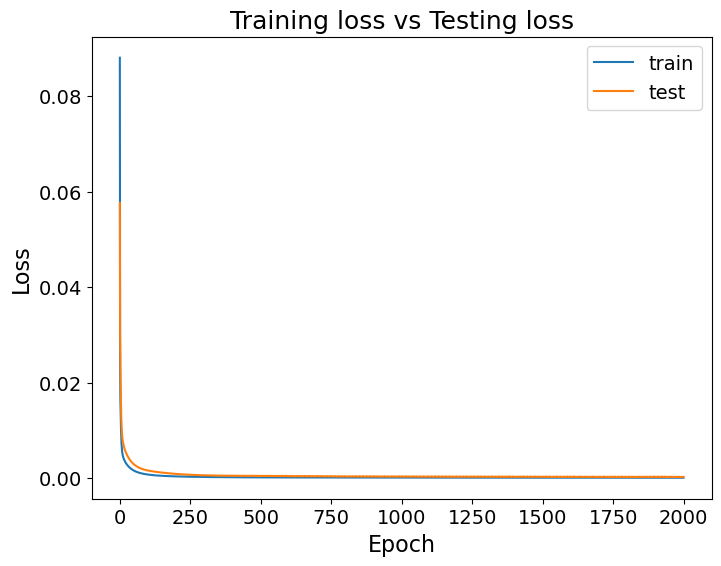

In [34]:
lr = 0.00001
EPOCHS = 2000
model_cnn.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('saved_model/cnn_shift_s{}_k{}.h5'.format(S, K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model_cnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [35]:
# model_cnn.save('saved_model/cnn1D_shifting_3day_18h')

In [36]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/cnn_shift_s{}_k{}.h5'.format(S, K))

In [37]:
# model_load.predict(test_input).shape

### Performance

In [38]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19270, 48) (19270, 48)


In [39]:
# inv_y

In [40]:
# inv_yhat

In [42]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.0581
RMSE = 0.0791
